In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
import os
import tarfile
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import ParameterGrid
import itertools
!pip install optuna
import optuna


In [ ]:
# .tar dosyasını açma
with tarfile.open("/content/drive/MyDrive/Yapay Sinir Aglari/256_ObjectCategories.tar", "r") as tar:
    tar.extractall("/content/drive/MyDrive/Yapay Sinir Aglari/Veri_Seti/256_Object_Categories")  # Çıkarılacak hedef klasör

# 256_ObjectCategories Veri Seti İçerisindeki Sınıfların Gösterimi

             Category  Count
0       111.house-fly     84
1       078.fried-egg     90
2    162.picnic-table     91
3           125.knife    101
4       142.microwave    107
..                ...    ...
252    027.calculator    100
253         028.camel    110
254        029.cannon    103
255         030.canoe    104
256      031.car-tire     90

[257 rows x 2 columns]


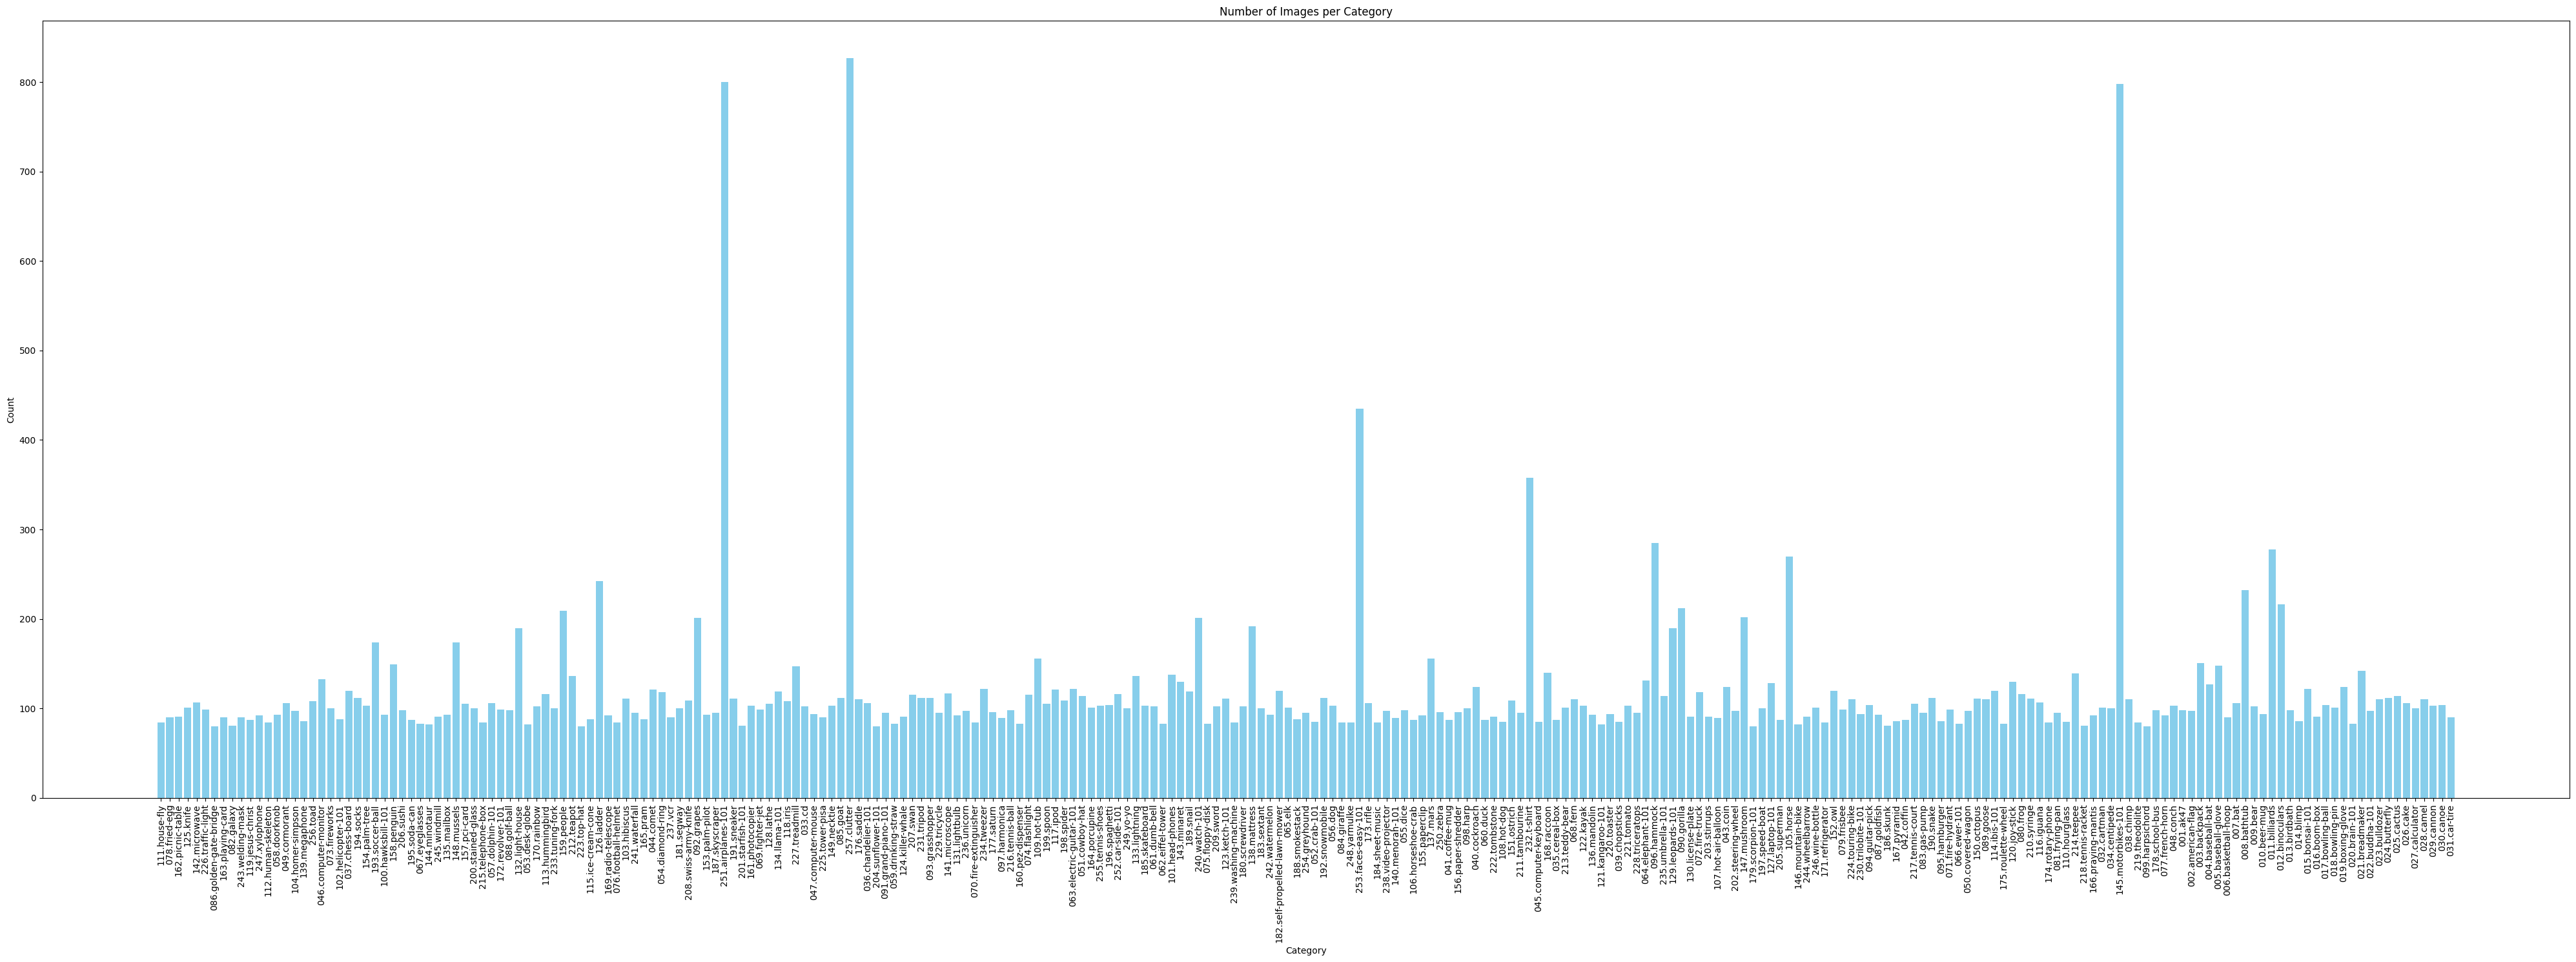

In [ ]:
# Veri seti yolunu belirtin
data = "/content/drive/MyDrive/Yapay Sinir Aglari/Veri_Seti/256_Object_Categories/256_ObjectCategories"

# Her klasördeki görüntü sayısını saymak için bir sözlük
category_counts = {}

# Klasörleri ve içindeki dosyaları dolaşarak kategori bilgilerini çıkarma
for folder_name in os.listdir(data):
    folder_path = os.path.join(data, folder_name)
    if os.path.isdir(folder_path):  # Klasör olduğundan emin olun
        # Klasördeki dosya sayısını hesaplayın
        num_images = len(os.listdir(folder_path))
        category_counts[folder_name] = num_images

# Analiz sonuçlarını DataFrame'e dönüştürün
category_df = pd.DataFrame(category_counts.items(), columns=["Category", "Count"])

# Kategorilerin dengeli olup olmadığını kontrol et
print(category_df)

# Görselleştirme: Her kategorideki görüntü sayısını çubuk grafikle göster
plt.figure(figsize=(40, 15))
plt.bar(category_df["Category"], category_df["Count"], color="skyblue")
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Number of Images per Category")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 256_ObjectCategories Veri Seti İçerisindeki 250 Adetten Fazla Görüntü Verisine Sahip Olan Sınıfların Dağılımı

---



In [ ]:
'''
# Checking the structure of the extracted directory
extracted_classes = [folder for folder in os.listdir(data) if os.path.isdir(os.path.join(data, folder))]

# Dictionary to store class and their image counts
class_image_counts = {}

# Iterate through the extracted classes, not the string data_dir
for class_folder in extracted_classes:
    class_path = os.path.join(data, class_folder)
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    class_image_counts[class_folder] = len(images)

# Filtering classes with less than 100 images
filtered_classes = {k: v for k, v in class_image_counts.items() if v >= 250}

# Preparing the filtered dataset path
filtered_path = '/content/drive/MyDrive/Yapay Sinir Aglari/Veri_Seti/Filtered_Classes'
os.makedirs(filtered_path, exist_ok=True)

# Assuming 'extraction_path' should be 'data_dir' based on the context
for class_folder in filtered_classes.keys():
    original_path = os.path.join(data_dir, class_folder) # Changed extraction_path to data_dir
    new_path = os.path.join(filtered_path, class_folder)
    os.makedirs(new_path, exist_ok=True)
    for img in os.listdir(original_path):
        if img.lower().endswith(('.png', '.jpg', '.jpeg')):
            os.rename(os.path.join(original_path, img), os.path.join(new_path, img))

filtered_classes_df = pd.DataFrame(list(filtered_classes.items()), columns=["Class Name", "Image Count"])
'''

             Category  Count
0         096.hammock    285
1  253.faces-easy-101    435
2   251.airplanes-101    800
3       011.billiards    278
4           105.horse    270
5         232.t-shirt    358
6         257.clutter    827
7  145.motorbikes-101    798


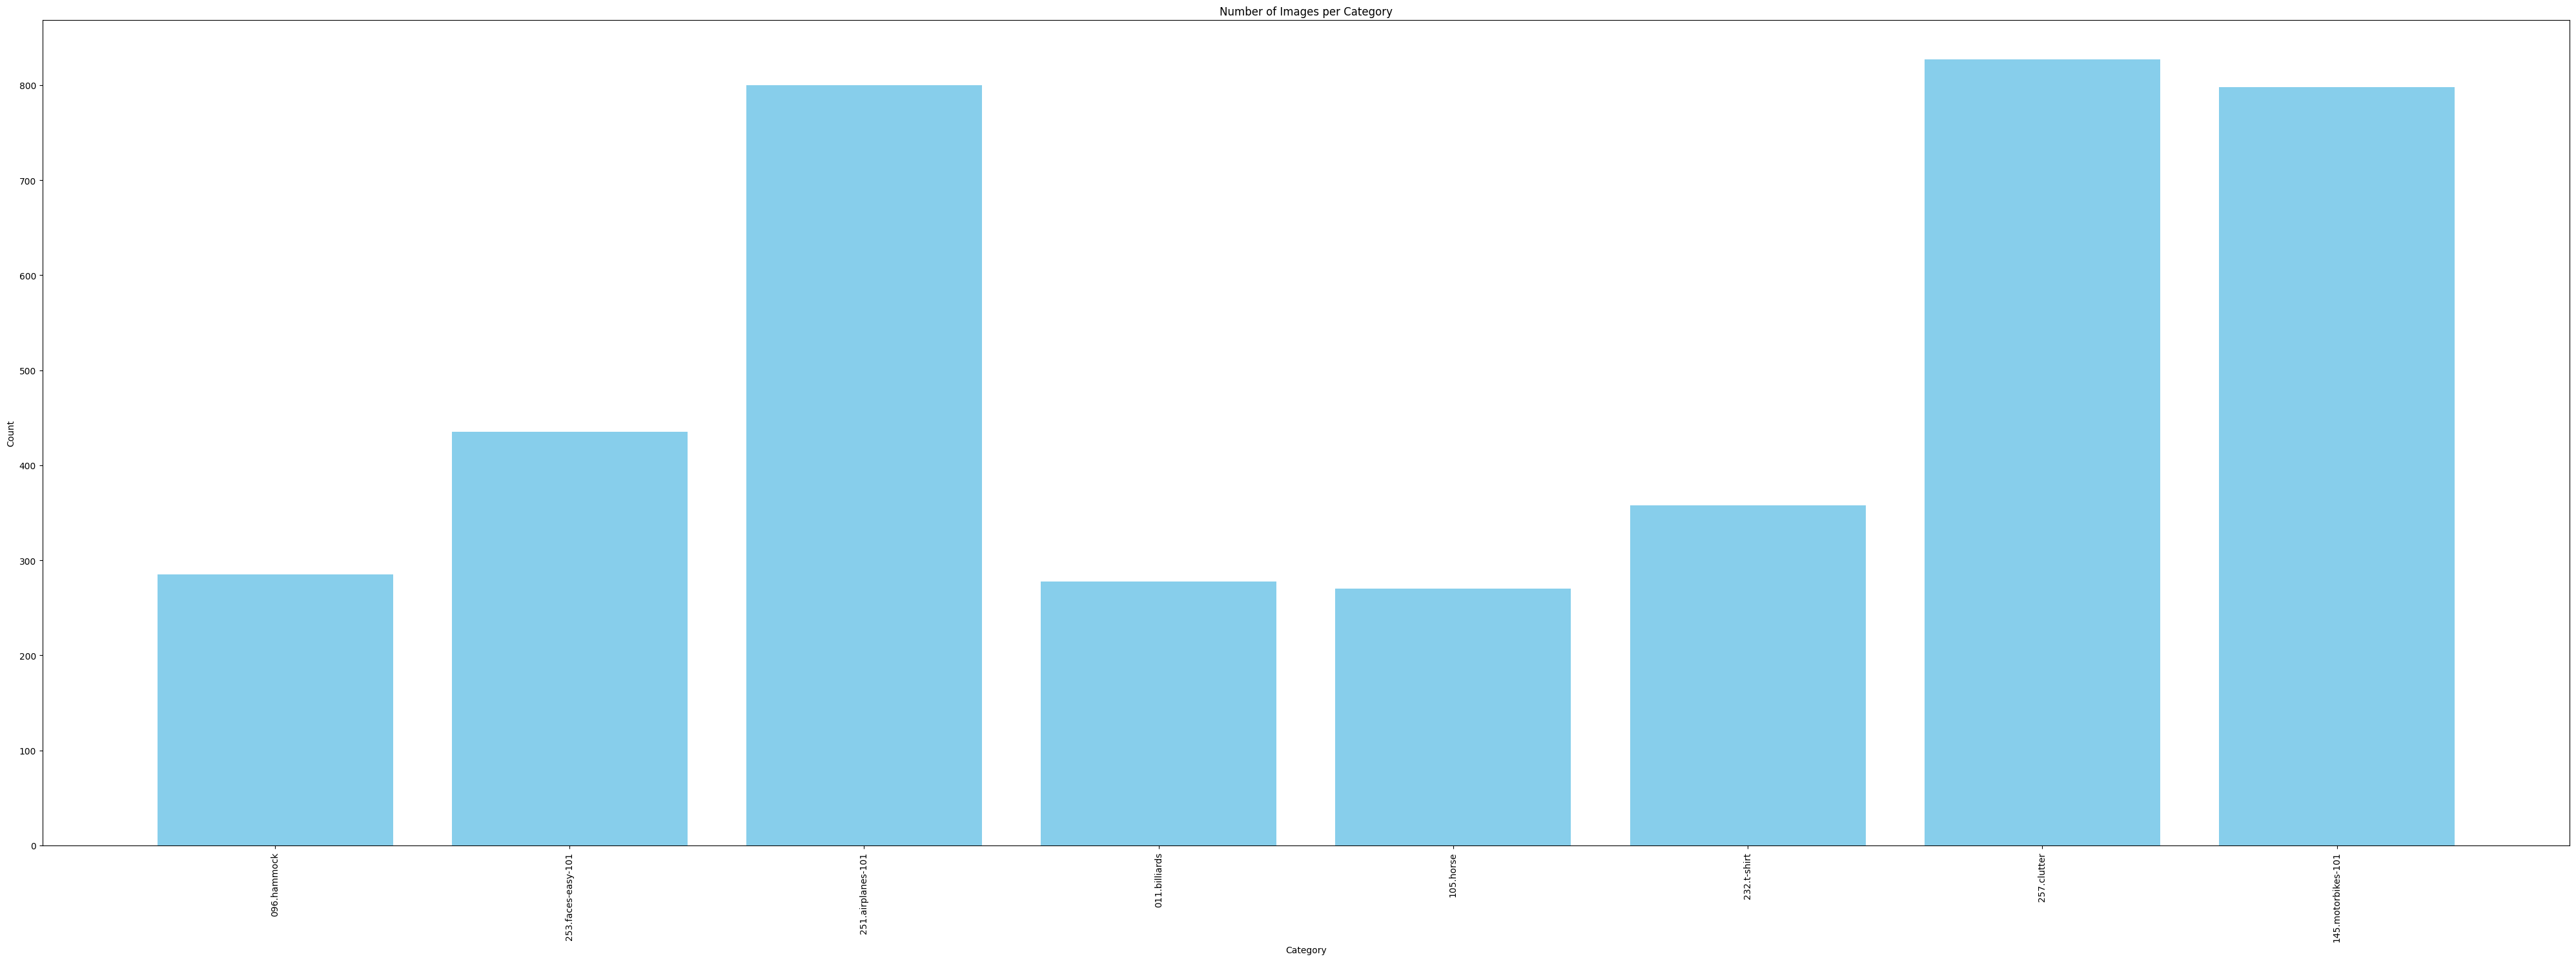

In [7]:
# Veri seti yolunu belirtin
data_dir = "/content/drive/MyDrive/Yapay Sinir Aglari/Veri_Seti/Filtered_Classes"

# Her klasördeki görüntü sayısını saymak için bir sözlük
category_counts = {}

# Klasörleri ve içindeki dosyaları dolaşarak kategori bilgilerini çıkarma
for folder_name in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder_name)
    if os.path.isdir(folder_path):  # Klasör olduğundan emin olun
        # Klasördeki dosya sayısını hesaplayın
        num_images = len(os.listdir(folder_path))
        category_counts[folder_name] = num_images

# Analiz sonuçlarını DataFrame'e dönüştürün
category_df = pd.DataFrame(category_counts.items(), columns=["Category", "Count"])

# Kategorilerin dengeli olup olmadığını kontrol et
print(category_df)

# Görselleştirme: Her kategorideki görüntü sayısını çubuk grafikle göster
plt.figure(figsize=(40, 15))
plt.bar(category_df["Category"], category_df["Count"], color="skyblue")
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Number of Images per Category")
plt.xticks(rotation=90)
plt.tight_layout()

# 256_ObjectCategories Veri Seti İçerisindeki 150-250 Adet Görüntü Verisine Sahip Olan Sınıfların Dağılımı

In [ ]:
'''
# Adjusting the code to filter classes with 150-250 images, limiting to 50 classes
max_classes = 50  # Maximum number of classes
min_images = 150  # Minimum number of images
max_images = 250  # Maximum number of images

# Dictionary to store filtered class counts
filtered_classes = {k: v for k, v in class_image_counts.items() if min_images <= v <= max_images}

# Limiting to maximum 50 classes
filtered_classes = dict(list(filtered_classes.items())[:max_classes])

# Preparing the filtered dataset path
filtered_path = '/content/drive/MyDrive/Yapay Sinir Aglari/Veri_Seti/Filtered_Classes2'
os.makedirs(filtered_path, exist_ok=True)

# Moving images of filtered classes
for class_folder in filtered_classes.keys():
    original_path = os.path.join(data, class_folder)
    new_path = os.path.join(filtered_path, class_folder)
    os.makedirs(new_path, exist_ok=True)
    for img in os.listdir(original_path):
        if img.lower().endswith(('.png', '.jpg', '.jpeg')):
            os.rename(os.path.join(original_path, img), os.path.join(new_path, img))

# Creating a DataFrame to summarize the filtered classes
filtered_classes_df = pd.DataFrame(list(filtered_classes.items()), columns=["Class Name", "Image Count"])
'''


            Category  Count
0           137.mars    156
1    193.soccer-ball    174
2   129.leopards-101    190
3       138.mattress    192
4        148.mussels    174
5       003.backpack    151
6      240.watch-101    201
7        090.gorilla    212
8         159.people    209
9         092.grapes    201
10      147.mushroom    202
11   132.light-house    190
12       109.hot-tub    156
13       008.bathtub    232
14        126.ladder    242
15    012.binoculars    216


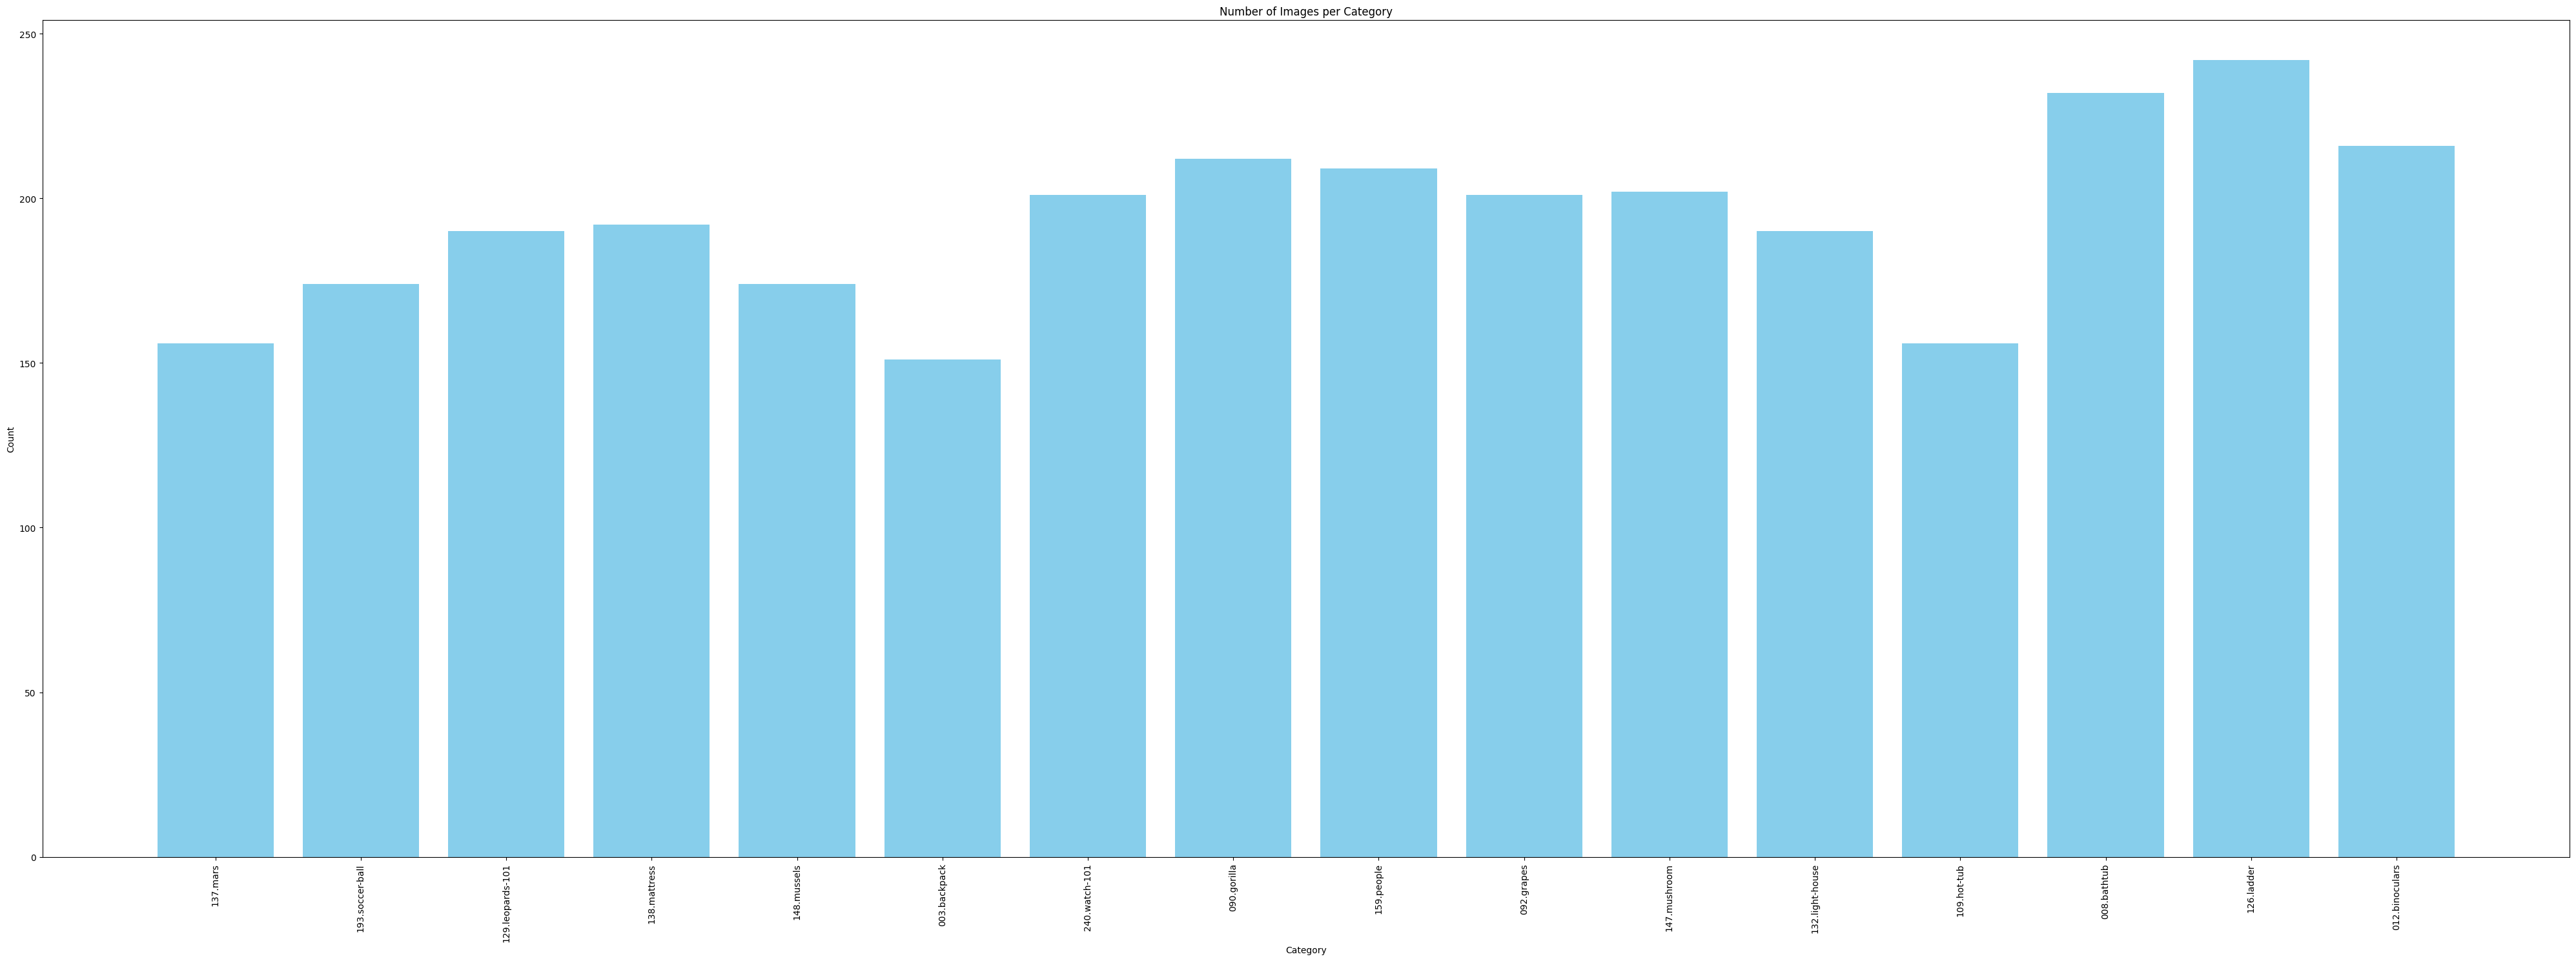

In [6]:
# Veri seti yolunu belirtin
data_dir2 = "/content/drive/MyDrive/Yapay Sinir Aglari/Veri_Seti/Filtered_Classes2"

# Her klasördeki görüntü sayısını saymak için bir sözlük
category_counts = {}

# Klasörleri ve içindeki dosyaları dolaşarak kategori bilgilerini çıkarma
for folder_name in os.listdir(data_dir2):
    folder_path = os.path.join(data_dir2, folder_name)
    if os.path.isdir(folder_path):  # Klasör olduğundan emin olun
        # Klasördeki dosya sayısını hesaplayın
        num_images = len(os.listdir(folder_path))
        category_counts[folder_name] = num_images

# Analiz sonuçlarını DataFrame'e dönüştürün
category_df = pd.DataFrame(category_counts.items(), columns=["Category", "Count"])

# Kategorilerin dengeli olup olmadığını kontrol et
print(category_df)

# Görselleştirme: Her kategorideki görüntü sayısını çubuk grafikle göster
plt.figure(figsize=(40, 15))
plt.bar(category_df["Category"], category_df["Count"], color="skyblue")
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Number of Images per Category")
plt.xticks(rotation=90)
plt.tight_layout()

# 256_ObjectCategories Veri Seti MLP Eğitimi


İmage resize işlemi

In [ ]:
def resize_with_aspect_ratio(image_path, target_size):
    img = Image.open(image_path).convert("RGB")
    img.thumbnail(target_size, Image.Resampling.LANCZOS)  # En-boy oranını koruyarak küçült
    new_img = Image.new("RGB", target_size, (255, 255, 255))  # Arka planı beyaz yap
    new_img.paste(img, ((target_size[0] - img.size[0]) // 2,
                        (target_size[1] - img.size[1]) // 2))
    return np.array(new_img).flatten() / 255.0

# Görsellerin yüklenmesi ve işlenmesi
target_size = (32, 32)  # Görselleri 128x128 piksel boyutuna ayarlıyoruz

images = []
labels = []

categories = os.listdir(data)  # Klasörleri listele
for category in categories:
    category_path = os.path.join(data, category)
    if os.path.isdir(category_path):
        for image_file in os.listdir(category_path):
            if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(category_path, image_file)
                try:
                    # Görüntüyü yeniden boyutlandır
                    resized_image = resize_with_aspect_ratio(image_path, target_size)
                    images.append(resized_image)  # Görüntüyü listeye ekle
                    labels.append(category)  # Klasör adını etiket olarak ekle
                except Exception as e:
                    print(f"Error processing image {image_path}: {e}")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-ffc2e85e1f05>", line 24, in <cell line: 16>
    resized_image = resize_with_aspect_ratio(image_path, target_size)
  File "<ipython-input-6-ffc2e85e1f05>", line 2, in resize_with_aspect_ratio
    img = Image.open(image_path).convert("RGB")
  File "/usr/local/lib/python3.10/dist-packages/PIL/Image.py", line 3480, in open
    prefix = fp.read(16)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (m

TypeError: object of type 'NoneType' has no len()

In [ ]:
np.save('/content/drive/MyDrive/Yapay Sinir Aglari/images.npy', images)
np.save('/content/drive/MyDrive/Yapay Sinir Aglari/labels.npy', labels)
print("Özellikler ve etiketler başarıyla kaydedildi.")

Özellikler ve etiketler başarıyla kaydedildi.


In [ ]:
images = np.load('/content/drive/MyDrive/Yapay Sinir Aglari/images.npy')
labels = np.load('/content/drive/MyDrive/Yapay Sinir Aglari/labels.npy')

In [ ]:
# NumPy dizilerine dönüştür
images = np.array(images)
labels = np.array(labels)

In [ ]:
# Veri setinin boyutunu kontrol edelim
print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")

Images shape: (30607, 3072), Labels shape: (30607,)


In [ ]:
# Etiketleri sayısal hale getirin
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
print(f"Labels shape (encoded): {labels_encoded.shape}")

Labels shape (encoded): (30607,)


In [ ]:
# One-hot encoded
labelonehot = OneHotEncoder(sparse_output=False).fit_transform(labels_encoded.reshape(-1, 1))
print(f"Labels shape (one-hot): {labelonehot.shape}")

Labels shape (one-hot): (30607, 257)


In [ ]:
# Eğitim ve test seti olarak ayır
X_train, X_test, y_train, y_test = train_test_split(images, labelonehot, test_size=0.2, random_state=42, stratify=labels)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (24485, 3072), Test shape: (6122, 3072)


In [ ]:

# Standartlaştırma
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Hiperparametre Denemesi

In [ ]:
# Hiperparametre seçenekleri
param_grid = {
    'hidden_layer_sizes': [(64,), (128,), (256, 128), (512, 256)],  # Gizli katman boyutları
    'activation': ['relu', 'tanh', 'logistic'],                    # Aktivasyon fonksiyonları
    'solver': ['adam', 'sgd'],                            # Optimizasyon algoritmaları
    'alpha': [0.0001, 0.001, 0.01],                                # L2 düzenleme parametresi
    'max_iter': [200, 300, 400]                                    # Maksimum iterasyon sayısı
}

# Parametre kombinasyonlarını oluştur
param_combinations = list(itertools.product(
    param_grid['hidden_layer_sizes'],
    param_grid['activation'],
    param_grid['solver'],
    param_grid['alpha'],
    param_grid['max_iter']
))

best_accuracy = 0
best_params = None
best_model = None

# Hiperparametre kombinasyonlarını dene
for params in param_combinations:
    hidden_layer_sizes, activation, solver, alpha, max_iter = params
    print(f"Training with params: {params}")

    # Modeli oluştur
    mlp = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver=solver,
        alpha=alpha,
        max_iter=max_iter,
        random_state=42
    )

    # Modeli eğit
    mlp.fit(X_train, y_train)

    # Test setinde değerlendirme
    y_pred = mlp.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy:.4f}")

    # En iyi modeli sakla
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params
        best_model = mlp

# En iyi sonuçları yazdır
print("\nBest Parameters:")
print(f"Hidden Layer Sizes: {best_params[0]}")
print(f"Activation: {best_params[1]}")
print(f"Solver: {best_params[2]}")
print(f"Alpha: {best_params[3]}")
print(f"Max Iter: {best_params[4]}")
print(f"Best Test Accuracy: {best_accuracy:.4f}")

# Sınıflandırma raporu
y_pred = best_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Training with params: ((64,), 'relu', 'adam', 0.0001, 200)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Test Accuracy: 0.0827
Training with params: ((64,), 'relu', 'adam', 0.0001, 300)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Test Accuracy: 0.0807
Training with params: ((64,), 'relu', 'adam', 0.0001, 400)


In [ ]:
# MLPClassifier Modeli Tanımlama
mlp = MLPClassifier(
    hidden_layer_sizes=(512, 256),  # Gizli katman boyutları
    activation='relu',             # Aktivasyon fonksiyonu
    solver='adam',                 # Optimizer
    max_iter=300,                  # Maksimum iterasyon sayısı
    random_state=42                # Rastgelelik için sabit değer
)

In [ ]:
# Modeli eğit
print("Model eğitiliyor...")
mlp.fit(X_train, y_train)

Model eğitiliyor...


MLPClassifier(hidden_layer_sizes=(512, 256), max_iter=300, random_state=42)

In [ ]:
# Tahminleri al
y_pred = mlp.predict(X_test)

# Doğruluk skorunu hesapla
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.12054884024828487


In [ ]:
# Ek bilgiler: Confusion Matrix ve Classification Report
from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
                               precision    recall  f1-score   support

                     001.ak47       0.25      0.05      0.08        20
            002.american-flag       0.40      0.11      0.17        19
                 003.backpack       0.50      0.30      0.38        30
             004.baseball-bat       0.43      0.12      0.19        25
           005.baseball-glove       0.23      0.23      0.23        30
          006.basketball-hoop       0.17      0.11      0.13        18
                      007.bat       0.00      0.00      0.00        21
                  008.bathtub       0.00      0.00      0.00        47
                     009.bear       0.00      0.00      0.00        20
                 010.beer-mug       0.00      0.00      0.00        19
                011.billiards       0.20      0.16      0.18        56
               012.binoculars       0.57      0.30      0.39        43
                 013.birdbath       0.00      0.00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ValueError: multilabel-indicator is not supported

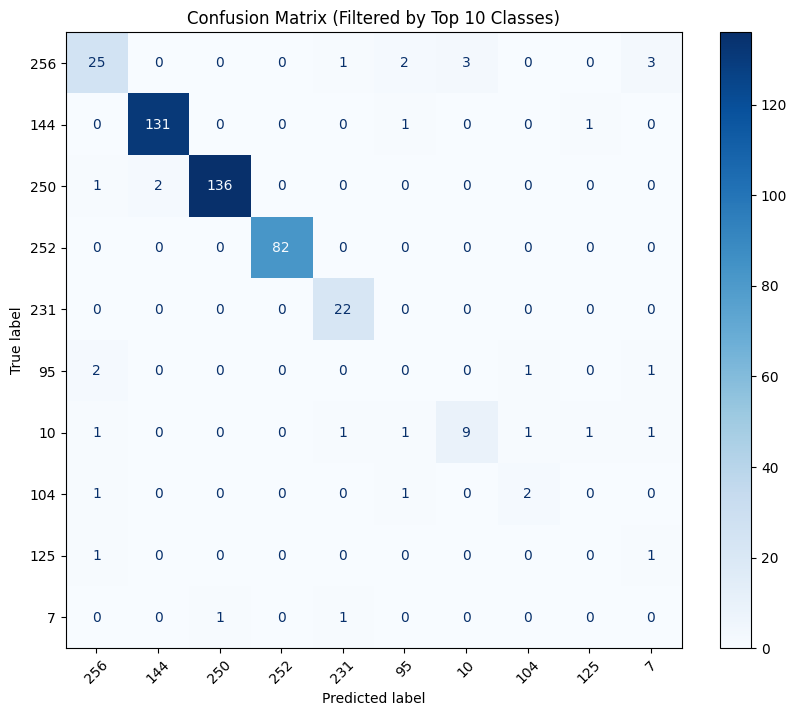

In [ ]:
# Sınıf dağılımını kontrol et
y_test_1d = np.argmax(y_test, axis=1)  # One-hot encoded ise orijinal etiketleri al
# veya y_test_1d = y_test.flatten()  # Eğer y_test zaten 1 boyutlu ise

class_counts = pd.Series(y_test_1d).value_counts()

# En çok örneği olan ilk 10 sınıfı seç
top_classes = class_counts.head(10).index

# Filtrelenmiş y_test ve y_pred
# Değişiklik burada: y_test_1d kullanarak indeksleri filtrele
filtered_indices = [i for i, label in enumerate(y_test_1d) if label in top_classes]
filtered_y_test = y_test[filtered_indices]
filtered_y_pred = y_pred[filtered_indices]

# Filtrelenmiş confusion matrix
cm_filtered = confusion_matrix(filtered_y_test.argmax(axis=1), filtered_y_pred.argmax(axis=1), labels=top_classes) # Değişiklik burada: argmax kullanarak sınıfları al

# Görselleştirme
disp = ConfusionMatrixDisplay(confusion_matrix=cm_filtered, display_labels=top_classes)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.xticks(rotation=45)
plt.title("Confusion Matrix (Filtered by Top 10 Classes)")
plt.show()

# `**MODELİN DEĞERLENDİLMESİ**`

Bu modelde, bazı sınıflarda çoz sayıda örnek varken, bazı sınıflarda daha fazla örnek vardır. Bu durum, modelin düşük veriye sahip sınıflara yeterince öğrenme kapasitesi ayıramamasına neden olmaktadır. Model ağırlıklı olarak yüksek veriye sahip sınıfları öğrenir ve düşük veriye sahip sınıfları tahmin etmekte zorlanır. Sonuç olarak, accuracy değeri düşer ve modelin recall değeri verisi düşük sınıflar için sıfıra yaklaşır.

# 256_ObjectCategories Veri Seti İçerisindeki 250 Adet Ve Üzeri Görüntü Verisine Sahip Olan Sınıfların MLP Modeliyle Eğitilmesi

In [ ]:
def resize_with_aspect_ratio(image_path, target_size):
    img = Image.open(image_path).convert("RGB")
    img.thumbnail(target_size, Image.Resampling.LANCZOS)  # En-boy oranını koruyarak küçült
    new_img = Image.new("RGB", target_size, (255, 255, 255))  # Arka planı beyaz yap
    new_img.paste(img, ((target_size[0] - img.size[0]) // 2,
                        (target_size[1] - img.size[1]) // 2))
    return np.array(new_img).flatten() / 255.0

# Görsellerin yüklenmesi ve işlenmesi
target_size = (32, 32)  # Görselleri 128x128 piksel boyutuna ayarlıyoruz

images1 = []
labels1 = []

categories = os.listdir(data_dir)  # Klasörleri listele
for category in categories:
    category_path = os.path.join(data_dir, category)
    if os.path.isdir(category_path):
        for image_file in os.listdir(category_path):
            if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(category_path, image_file)
                try:
                    # Görüntüyü yeniden boyutlandır
                    resized_image = resize_with_aspect_ratio(image_path, target_size)
                    images1.append(resized_image)  # Görüntüyü listeye ekle
                    labels1.append(category)  # Klasör adını etiket olarak ekle
                except Exception as e:
                    print(f"Error processing image {image_path}: {e}")

In [ ]:
# NumPy dizilerine dönüştür
images1 = np.array(images1)
labels1 = np.array(labels1)

In [ ]:
# Veri setinin boyutunu kontrol edelim
print(f"Images shape: {images1.shape}, Labels shape: {labels1.shape}")

Images shape: (4051, 3072), Labels shape: (4051,)


In [ ]:
# Etiketleri sayısal hale getirin
label_encoder = LabelEncoder()
labels1_encoded = label_encoder.fit_transform(labels1)
print(f"Labels shape (encoded): {labels1_encoded.shape}")

Labels shape (encoded): (4051,)


In [ ]:
# One-hot encoded
labelonehot = OneHotEncoder(sparse_output=False).fit_transform(labels1_encoded.reshape(-1, 1))
print(f"Labels shape (one-hot): {labelonehot.shape}")

Labels shape (one-hot): (4051, 8)


In [ ]:
# Eğitim ve test seti olarak ayır
X_train, X_test, y_train, y_test = train_test_split(images1, labels1_encoded, test_size=0.2, random_state=42, stratify=labels1)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (3240, 3072), Test shape: (811, 3072)


In [ ]:
# Standartlaştırma
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**Hiperparametre Denemesi**

In [ ]:


# Optuna hedef fonksiyonunu tanımlayın
def objective(trial):
    # Hiperparametreleri öner
    hidden_layer_sizes = trial.suggest_categorical(
        'hidden_layer_sizes', ['64', '128', '256-128', '512-256']
    )
    # Tuple formatına dönüştür
    hidden_layer_sizes = tuple(map(int, hidden_layer_sizes.split('-')))

    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic'])
    solver = trial.suggest_categorical('solver', ['adam', 'sgd'])
    alpha = trial.suggest_float('alpha', 0.0001, 0.01, log=True)  # suggest_loguniform yerine
    max_iter = trial.suggest_int('max_iter', 200, 400)

    # Modeli tanımlayın
    mlp = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver=solver,
        alpha=alpha,
        max_iter=max_iter,
        random_state=42
    )

    # Modeli eğit ve test et
    try:
        mlp.fit(X_train, y_train)
        y_pred = mlp.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
    except Exception as e:
        # Bazı hiperparametreler başarısız olabilir, düşük bir skor döndür
        return 0.0

    return accuracy  # Hedef, doğruluğu maksimize etmektir

# Optuna çalışmasını başlatın
study = optuna.create_study(direction='maximize')  # Doğruluğu maksimize etmek için
study.optimize(objective, n_trials=50)  # 50 deneme yap

# En iyi hiperparametreleri yazdırın
print("\nBest Parameters:")
print(study.best_params)
print(f"Best Test Accuracy: {study.best_value:.4f}")

# En iyi modeli eğitin ve değerlendirin
best_params = study.best_params
hidden_layer_sizes = tuple(map(int, best_params['hidden_layer_sizes'].split('-')))

best_model = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes,
    activation=best_params['activation'],
    solver=best_params['solver'],
    alpha=best_params['alpha'],
    max_iter=best_params['max_iter'],
    random_state=42
)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Sınıflandırma raporunu yazdır
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



[I 2024-11-27 21:59:53,705] A new study created in memory with name: no-name-37646442-dab6-4c43-b182-e8d60c548a5a
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (282) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2024-11-27 22:13:44,378] Trial 0 finished with value: 0.6177558569667078 and parameters: {'hidden_layer_sizes': '128', 'activation': 'logistic', 'solver': 'sgd', 'alpha': 0.0006884232700432752, 'max_iter': 282}. Best is trial 0 with value: 0.6177558569667078.
[I 2024-11-27 22:17:52,776] Trial 1 finished with value: 0.55980271270037 and parameters: {'hidden_layer_sizes': '256-128', 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.00031945337867138996, 'max_iter': 207}. Best is trial 0 with value: 0.6177558569667078.
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimi


Best Parameters:
{'hidden_layer_sizes': '512-256', 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00036565502863690637, 'max_iter': 262}
Best Test Accuracy: 0.7127

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.36      0.46        56
           1       0.50      0.16      0.24        57
           2       0.53      0.19      0.27        54
           3       0.98      0.89      0.93       160
           4       0.69      0.71      0.70        72
           5       0.92      0.94      0.93       160
           6       0.99      0.97      0.98        87
           7       0.65      0.76      0.70       165

   micro avg       0.81      0.73      0.77       811
   macro avg       0.74      0.62      0.65       811
weighted avg       0.79      0.73      0.74       811
 samples avg       0.72      0.73      0.72       811



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from joblib import dump

# Modeli kaydedin
dump(best_model, 'mlp_model.joblib')
print("Model başarıyla kaydedildi: mlp_model.joblib")



In [ ]:
# MLPClassifier Modeli Tanımlama
mlp = MLPClassifier(
    hidden_layer_sizes=(512, 256),  # Gizli katman boyutları
    activation='relu',             # Aktivasyon fonksiyonu
    solver='adam',                 # Optimizer
    max_iter=350,                  # Maksimum iterasyon sayısı
    random_state=42                # Rastgelelik için sabit değer
)

In [ ]:
# Modeli eğit
print("Model eğitiliyor...")
mlp.fit(X_train, y_train)

Model eğitiliyor...


MLPClassifier(hidden_layer_sizes=(512, 256), max_iter=350, random_state=42)

In [ ]:
# Tahminleri al
y_pred = mlp.predict(X_test)

# Doğruluk skorunu hesapla
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7718865598027127


In [ ]:
# Ek bilgiler: Confusion Matrix ve Classification Report
from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
                    precision    recall  f1-score   support

     011.billiards       0.48      0.46      0.47        56
       096.hammock       0.25      0.12      0.16        57
         105.horse       0.41      0.41      0.41        54
145.motorbikes-101       0.94      0.98      0.96       160
       232.t-shirt       0.77      0.60      0.67        72
 251.airplanes-101       0.99      0.96      0.98       160
253.faces-easy-101       0.97      0.97      0.97        87
       257.clutter       0.63      0.81      0.71       165

          accuracy                           0.77       811
         macro avg       0.68      0.66      0.67       811
      weighted avg       0.76      0.77      0.76       811

Confusion Matrix:
[[ 26   3  10   1   1   0   0  15]
 [ 11   7  11   2   4   0   0  22]
 [  4   6  22   0   5   0   1  16]
 [  0   1   0 157   0   0   0   2]
 [  2   2   7   1  43   0   0  17]
 [  0   0   0   4   0 154   0   2]
 [  0   0   0   0   0   0 

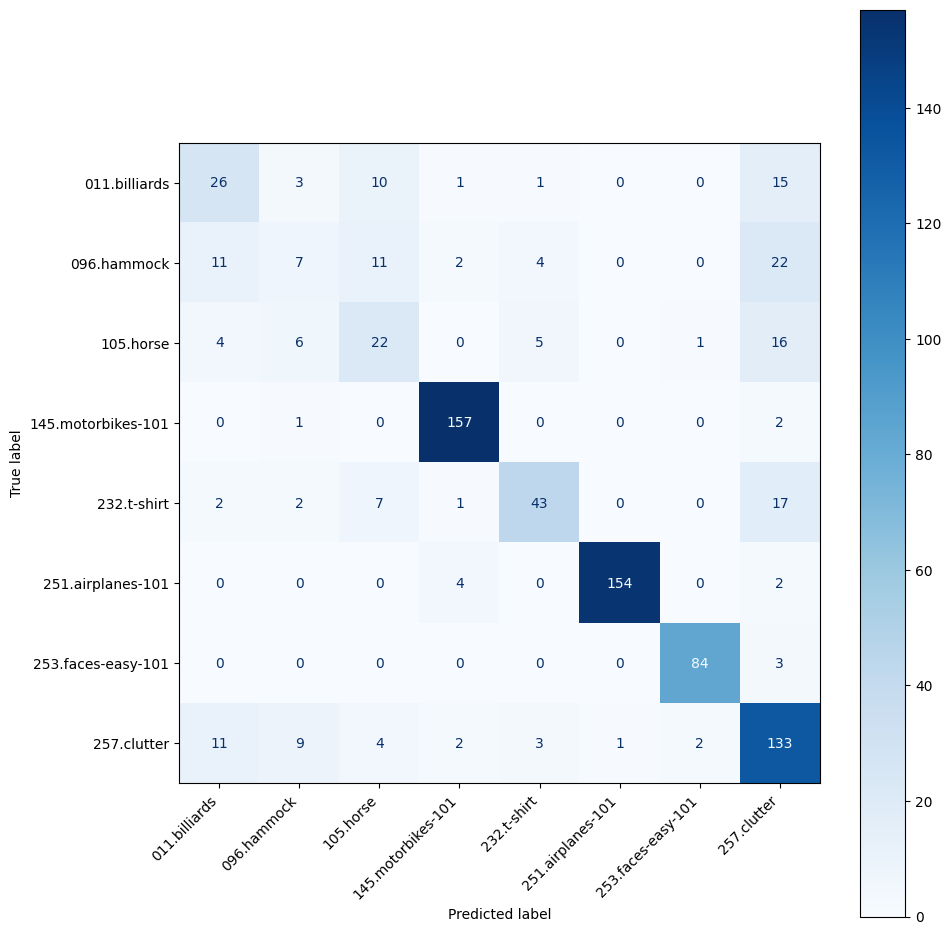

In [ ]:
# prompt: confusion matrix görselini oluştururmusun

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Assuming y_test and y_pred are defined from your previous code
# ... (your existing code) ...

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

# `**MODELİN DEĞERLENDİRİLMESİ**`

Bu modelde sadece yeterli örnek sayısına (250 adet ve üzeri) sahip sınıflar seçilmiştir. Böylece, her bir sınıfın model tarafından öğrenilmesi için yeterli veri sağlanmıştır. Veri setinin tamamı ve 150-250 adet veri sınıflarından oluşan veri setinden daha dengeli ve yüksek veriye sahip sınıflar olduğu için model daha iyi performans göstermiştir.
Sonuç olarak accuracy değeri ve diğer metrikler önemli ölçüde iyileştiği görülmüştür.


Modelde hiperparametre denemesi yapılmıştır. Önerilen parametre ile denendiğinde en iyi parametreler;
{'hidden_layer_sizes': '512-256', 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00036565502863690637, 'max_iter': 262}
Best Test Accuracy: 0.7127
olarak bulunmuştur. Modeli tanımlarken alpha parametresi kullanılmamış olup iterasyon sayısı 350 olarak seçildiğinde accuracy değeri 0.77 olarak bulunmuştur.Hiperparametre denemesinde bulunan best parametre değerlerinden daha iyi bir sonuç elde edildiği görülmüştür.

# 256_ObjectCategories Veri Seti İçerisindeki 150-250 Adet Görüntü Verisine Sahip Olan Sınıfların MLP Modeliyle Eğitilmesi

In [ ]:
def resize_with_aspect_ratio(image_path, target_size):
    img = Image.open(image_path).convert("RGB")
    img.thumbnail(target_size, Image.Resampling.LANCZOS)  # En-boy oranını koruyarak küçült
    new_img = Image.new("RGB", target_size, (255, 255, 255))  # Arka planı beyaz yap
    new_img.paste(img, ((target_size[0] - img.size[0]) // 2,
                        (target_size[1] - img.size[1]) // 2))
    return np.array(new_img).flatten() / 255.0

# Görsellerin yüklenmesi ve işlenmesi
target_size = (32, 32)  # Görselleri 32x32 piksel boyutuna ayarlıyoruz

images2 = []
labels2 = []

categories = os.listdir(data_dir2)  # Klasörleri listele
for category in categories:
    category_path = os.path.join(data_dir2, category)
    if os.path.isdir(category_path):
        for image_file in os.listdir(category_path):
            if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(category_path, image_file)
                try:
                    # Görüntüyü yeniden boyutlandır
                    resized_image = resize_with_aspect_ratio(image_path, target_size)
                    images2.append(resized_image)  # Görüntüyü listeye ekle
                    labels2.append(category)  # Klasör adını etiket olarak ekle
                except Exception as e:
                    print(f"Error processing image {image_path}: {e}")
                    continue

In [ ]:
# NumPy dizilerine dönüştür
images2 = np.array(images2)
labels2 = np.array(labels2)

In [ ]:
# Veri setinin boyutunu kontrol edelim
print(f"Images shape: {images2.shape}, Labels shape: {labels2.shape}")

Images shape: (3098, 3072), Labels shape: (3098,)


In [ ]:
# Etiketleri sayısal hale getirin
label_encoder = LabelEncoder()
labels2_encoded = label_encoder.fit_transform(labels2)
print(f"Labels shape (encoded): {labels2_encoded.shape}")

Labels shape (encoded): (3098,)


In [ ]:
# One-hot encoded
labelonehot = OneHotEncoder(sparse_output=False).fit_transform(labels2_encoded.reshape(-1, 1))
print(f"Labels shape (one-hot): {labelonehot.shape}")

Labels shape (one-hot): (3098, 16)


In [ ]:
# Eğitim ve test seti olarak ayır
X_train, X_test, y_train, y_test = train_test_split(images2, labels2_encoded, test_size=0.2, random_state=42, stratify=labels2)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (2478, 3072), Test shape: (620, 3072)


In [ ]:
# Standartlaştırma
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# MLPClassifier Modeli Tanımlama
mlp = MLPClassifier(
    hidden_layer_sizes=(512, 256),  # Gizli katman boyutları
    activation='relu',             # Aktivasyon fonksiyonu
    solver='adam',                 # Optimizer
    max_iter=350,                  # Maksimum iterasyon sayısı
    random_state=42                # Rastgelelik için sabit değer
)

In [ ]:
# Modeli eğit
print("Model eğitiliyor...")
mlp.fit(X_train, y_train)

Model eğitiliyor...


MLPClassifier(hidden_layer_sizes=(512, 256), max_iter=350, random_state=42)

In [ ]:
# Tahminleri al
y_pred = mlp.predict(X_test)

# Doğruluk skorunu hesapla
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.4629032258064516


In [ ]:
# Ek bilgiler: Confusion Matrix ve Classification Report
from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
                  precision    recall  f1-score   support

    003.backpack       0.62      0.67      0.65        30
     008.bathtub       0.17      0.11      0.13        47
  012.binoculars       0.61      0.65      0.63        43
     090.gorilla       0.40      0.53      0.46        43
      092.grapes       0.41      0.30      0.35        40
     109.hot-tub       0.35      0.29      0.32        31
      126.ladder       0.13      0.20      0.16        49
129.leopards-101       0.86      0.95      0.90        38
 132.light-house       0.69      0.63      0.66        38
        137.mars       0.78      0.81      0.79        31
    138.mattress       0.40      0.63      0.49        38
    147.mushroom       0.25      0.35      0.29        40
     148.mussels       0.18      0.11      0.14        35
      159.people       0.17      0.10      0.12        42
 193.soccer-ball       0.29      0.11      0.16        35
   240.watch-101       0.66      0.62      0.64 

In [ ]:
# Sınıf dağılımını hesapla
unique, counts = np.unique(labels2, return_counts=True)

# Sınıf dağılımını bir sözlük olarak oluştur ve sıralama uygula
class_distribution = dict(zip(unique, counts))
sorted_class_distribution = sorted(class_distribution.items(), key=lambda x: x[1], reverse=True)

# Sınıf dağılımını göster (en büyükten en küçüğe)
print("Sınıf Dağılımı (En Büyükten En Küçüğe):")
for class_id, count in sorted_class_distribution:
    print(f"Sınıf {class_id}: {count} örnek")

# Toplam sınıf sayısını yazdır
print(f"\nToplam Sınıf Sayısı: {len(unique)}")

Sınıf Dağılımı (En Büyükten En Küçüğe):
Sınıf 126.ladder: 242 örnek
Sınıf 008.bathtub: 232 örnek
Sınıf 012.binoculars: 216 örnek
Sınıf 090.gorilla: 212 örnek
Sınıf 159.people: 209 örnek
Sınıf 147.mushroom: 202 örnek
Sınıf 092.grapes: 201 örnek
Sınıf 240.watch-101: 201 örnek
Sınıf 138.mattress: 192 örnek
Sınıf 129.leopards-101: 190 örnek
Sınıf 132.light-house: 190 örnek
Sınıf 148.mussels: 174 örnek
Sınıf 193.soccer-ball: 174 örnek
Sınıf 109.hot-tub: 156 örnek
Sınıf 137.mars: 156 örnek
Sınıf 003.backpack: 151 örnek

Toplam Sınıf Sayısı: 16


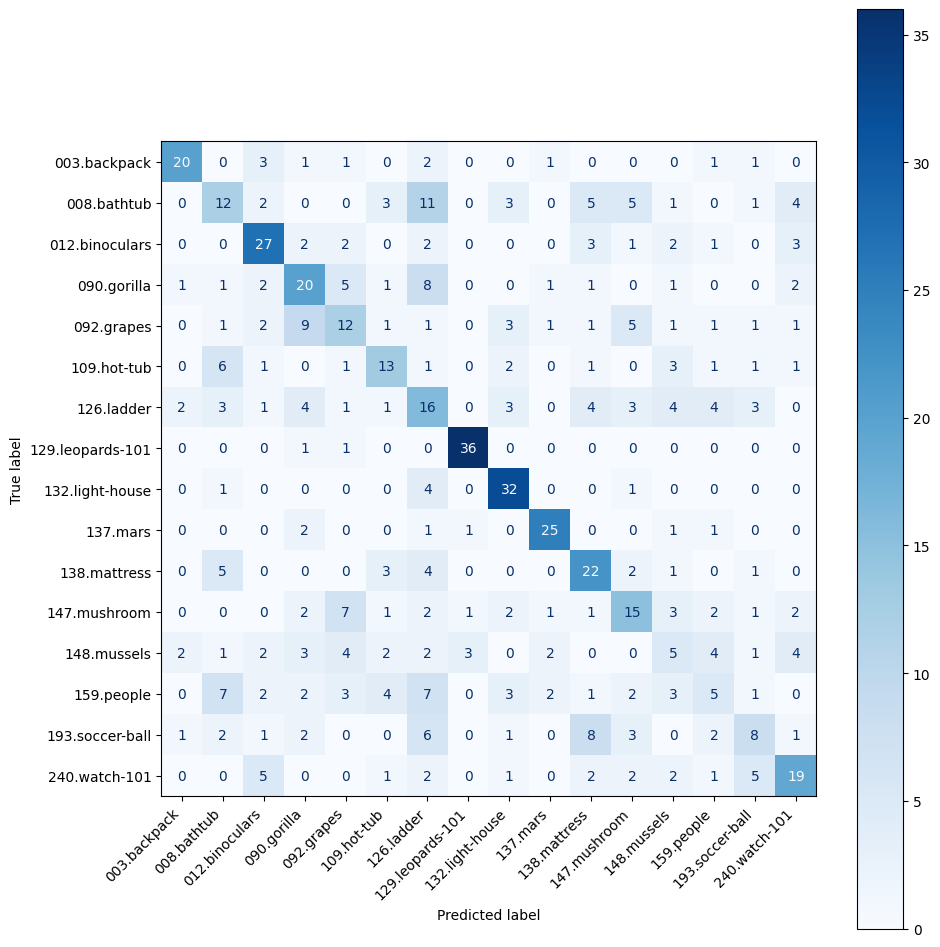

In [ ]:
# prompt: confusion matrix görselini oluştururmusun

# Assuming y_test and y_pred are defined from your previous code
# ... (your existing code) ...

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

# `**MODELİN DEĞERLENDİRİLMESİ**`

Seçilen sınıflar 150-250 arasında görüntü verisine sahiptir ve bu sayı, modelin her sınıfı yeterince öğrenebilmesi için sınırda bir seviyedir.
Örneğin '008.bathtu' ve '148.mussels' gibi sınıflar, daha düşük precision ve recall değerlerine sahiptir ve bu durum veri dağılımından ziyade görüntülerin boyut farklılıklarından kaynaklıdır. '008.bathtu' sınıfındaki görseller 425x500 piksel iken, '129.leopards-101' sınıfındaki görsel boyutları 192x128 pikseldir. Görüntüleri 32x32 piksel boyutuna standartlaştırırken '008.bathtu' sınıfındaki yüksek boyutlu resimlerin içerisindeki detayların kaybolmasınına sebebiyet verdiğini ve '129.leopards-101' sınıfının piksel boyutların küçük olması ve detayların daha öne çıktığı bilgisini recall değerlerine bakarak söyleyebilirim. Bu sebeble bazı sınıfların görüntüleri yüksek boyutta olması nedeniyle detay bilgileri kaybolduğu için burada performans kaybına neden olduğu ortaya çıkmaktadır.

# RFB Model Eğitimi

In [34]:
!pip install tensorflow
!pip install keras-tuner
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
from keras_tuner import HyperModel
from keras_tuner import RandomSearch


In [31]:
# Özel bir Radial Basis Function (RBF) katmanı
class RBFLayer(tf.keras.layers.Layer):
    def __init__(self, units, gamma=1.0, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = gamma

    def build(self, input_shape):
        self.centers = self.add_weight(
            name='centers',
            shape=(self.units, input_shape[-1]),
            initializer='uniform',
            trainable=True
        )
        self.betas = self.add_weight(
            name='betas',
            shape=(self.units,),
            initializer='ones',
            trainable=True
        )
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = tf.expand_dims(inputs, axis=1) - self.centers
        l2 = tf.reduce_sum(diff**2, axis=-1)
        return tf.exp(-self.betas * l2)

# Veri yükleme ve işleme
def prepare_data(data_dir, img_size=(32, 32), batch_size=32, validation_split=0.2):
    datagen = ImageDataGenerator(
        rescale=1./255,  # Normalize pixel values
        validation_split=validation_split
    )
    train_gen = datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        subset='training',
        class_mode='categorical',
        shuffle=True
    )
    val_gen = datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        subset='validation',
        class_mode='categorical',
        shuffle=False
    )
    return train_gen, val_gen

# RBF modeli oluşturma
def create_rbf_model(input_shape, num_classes, rbf_units=10, gamma=1.0):
        model = Sequential([
            Input(shape=input_shape),
            tf.keras.layers.Flatten(), # Add a Flatten layer to convert image to 1D
            RBFLayer(units=rbf_units, gamma=gamma),
            Dense(num_classes, activation='softmax')
        ])
        return model

**RFB MODELİ İÇİN HİPERPARAMETRE DENEMESİ**

In [ ]:
# Hiperparametre Fonksiyonu
class RBFLayer(tf.keras.layers.Layer):
    def __init__(self, units, gamma=1.0, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = gamma

    def build(self, input_shape):
        self.centers = self.add_weight(
            name='centers',
            shape=(self.units, input_shape[-1]),
            initializer='uniform',
            trainable=True
        )
        self.betas = self.add_weight(
            name='betas',
            shape=(self.units,),
            initializer='ones',
            trainable=True
        )
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = tf.expand_dims(inputs, axis=1) - self.centers
        l2 = tf.reduce_sum(diff**2, axis=-1)
        return tf.exp(-self.betas * l2)

class RBFHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        rbf_units = hp.Int('rbf_units', min_value=5, max_value=50, step=5)
        gamma = hp.Float('gamma', min_value=0.1, max_value=10.0, step=0.1)
        learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        model = tf.keras.Sequential([
            Input(shape=self.input_shape),
            tf.keras.layers.Flatten(),
            RBFLayer(units=rbf_units, gamma=gamma),
            Dense(self.num_classes, activation='softmax')
        ])

        model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

# Hiperparametre arama
def hyperparameter_search(data_dir, input_shape, num_classes, max_trials=5, executions_per_trial=2):
    train_gen, val_gen = prepare_data(data_dir, img_size=input_shape[:2])

    hypermodel = RBFHyperModel(input_shape=input_shape, num_classes=num_classes)

    tuner = RandomSearch(
        hypermodel,
        objective='val_accuracy',
        max_trials=max_trials,
        executions_per_trial=executions_per_trial,
        directory='rbf_tuning',
        project_name='rbf_model_tuning'
    )

    tuner.search(
        train_gen,
        validation_data=val_gen,
        epochs=10,
        verbose=2
    )

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"Best RBF Units: {best_hps.get('rbf_units')}")
    print(f"Best Gamma: {best_hps.get('gamma')}")
    print(f"Best Learning Rate: {best_hps.get('learning_rate')}")

    return tuner



**Veri Seti İçerisindeki 150-250 Adet Görüntü Verisine Sahip Olan Sınıfların RFB Modeli İçin Hiperparametre Denemesi**

In [46]:
# Veri ve model bilgileri
data_dir = "/content/drive/MyDrive/Yapay Sinir Aglari/Veri_Seti/Filtered_Classes2"
input_shape = (32, 32, 3)
num_classes = 16

# Hiperparametre araması yap
tuner = hyperparameter_search(data_dir, input_shape, num_classes)

Found 2484 images belonging to 16 classes.
Found 614 images belonging to 16 classes.
Reloading Tuner from rbf_tuning/rbf_model_tuning/tuner0.json
Best RBF Units: 40
Best Gamma: 8.7
Best Learning Rate: 0.0001


**Veri Seti İçerisindeki 250 Adet Ve Üzeri Görüntü Verisine Sahip Olan Sınıfların RFB Modeli İçin Hiperparametre Denemesi**

In [44]:
# Veri ve model bilgileri
data_dir = "/content/drive/MyDrive/Yapay Sinir Aglari/Veri_Seti/Filtered_Classes"
input_shape = (32, 32, 3)
num_classes = 16

# Hiperparametre araması yap
tuner = hyperparameter_search(data_dir, input_shape, num_classes)

Found 3243 images belonging to 8 classes.
Found 808 images belonging to 8 classes.
Reloading Tuner from rbf_tuning/rbf_model_tuning/tuner0.json
Best RBF Units: 40
Best Gamma: 8.7
Best Learning Rate: 0.0001


 **`Veri Seti İçerisindeki 150-250 Adet Görüntü Verisine Sahip Olan Sınıfların RFB Modeliyle Eğitilmesi`**

In [17]:
# Ana kod bloğu
if __name__ == "__main__":
    # Veri seti yolu (yerel veri setinizin bulunduğu dizini belirtin)
    data_dir3 = "/content/drive/MyDrive/Yapay Sinir Aglari/Veri_Seti/Filtered_Classes2"

    # Veri hazırlama
    train_gen, val_gen = prepare_data(data_dir3)

    # Giriş boyutu ve sınıf sayısı
    input_shape = train_gen.image_shape  # Get the image shape as a tuple
    num_classes = len(train_gen.class_indices)

    # RBF modelini oluştur ve derle
    rbf_model = create_rbf_model(input_shape=input_shape, num_classes=num_classes, rbf_units=50, gamma=1.0) # Pass input_shape
    rbf_model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Modelin özetini görüntüle
    rbf_model.summary()

    # Modeli eğit
    history = rbf_model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=10
    )

Found 2484 images belonging to 16 classes.
Found 614 images belonging to 16 classes.
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 3072)              0         
                                                                 
 rbf_layer_3 (RBFLayer)      (None, 50)                153650    
                                                                 
 dense_3 (Dense)             (None, 16)                816       
                                                                 
Total params: 154466 (603.38 KB)
Trainable params: 154466 (603.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
78/78 [==============================] - 14s 173ms/step - loss: 2.7720 - accuracy: 0.0757 - val_loss: 2.7708 - val_accuracy: 0.0782
Epoch 2/10
78/78 [==============================] 

In [18]:
# Modeli değerlendir
loss, accuracy = rbf_model.evaluate(val_gen)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

20/20 [==============================] - 2s 119ms/step - loss: 2.7646 - accuracy: 0.0782
Validation Loss: 2.7646, Validation Accuracy: 0.0782


20/20 [==============================] - 2s 96ms/step


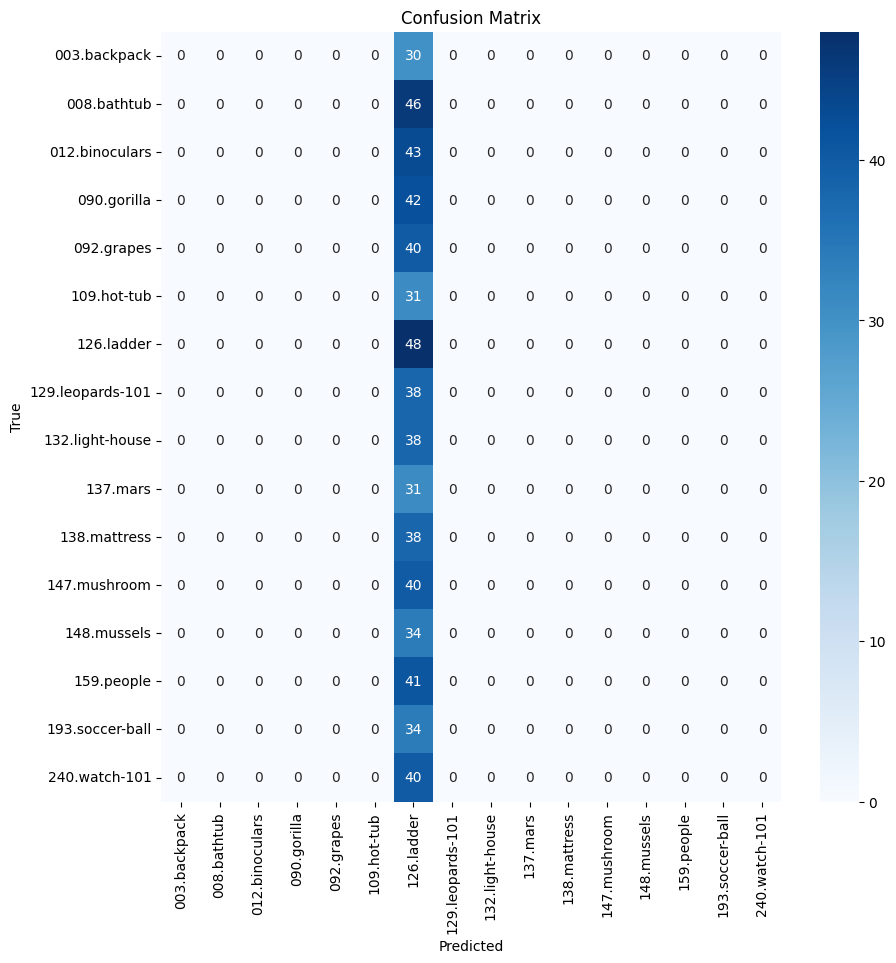

Classification Report:
                  precision    recall  f1-score   support

    003.backpack       0.00      0.00      0.00        30
     008.bathtub       0.00      0.00      0.00        46
  012.binoculars       0.00      0.00      0.00        43
     090.gorilla       0.00      0.00      0.00        42
      092.grapes       0.00      0.00      0.00        40
     109.hot-tub       0.00      0.00      0.00        31
      126.ladder       0.08      1.00      0.15        48
129.leopards-101       0.00      0.00      0.00        38
 132.light-house       0.00      0.00      0.00        38
        137.mars       0.00      0.00      0.00        31
    138.mattress       0.00      0.00      0.00        38
    147.mushroom       0.00      0.00      0.00        40
     148.mussels       0.00      0.00      0.00        34
      159.people       0.00      0.00      0.00        41
 193.soccer-ball       0.00      0.00      0.00        34
   240.watch-101       0.00      0.00      0.00 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
# Tahminler
y_true = val_gen.classes
y_pred = rbf_model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_gen.class_indices.keys(), yticklabels=val_gen.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
report = classification_report(y_true, y_pred_classes, target_names=val_gen.class_indices.keys())
print(report)

 **Veri Seti İçerisindeki 250 Adet Ve Üzeri Görüntü Verisine Sahip Olan Sınıfların RFB Modeliyle Eğitilmesi**

In [23]:
# Ana kod bloğu
if __name__ == "__main__":
    # Veri seti yolu (yerel veri setinizin bulunduğu dizini belirtin)
    data_dir4 = "/content/drive/MyDrive/Yapay Sinir Aglari/Veri_Seti/Filtered_Classes"

    # Veri hazırlama
    train_gen, val_gen = prepare_data(data_dir4)

    # Giriş boyutu ve sınıf sayısı
    input_shape = train_gen.image_shape  # Get the image shape as a tuple
    num_classes = len(train_gen.class_indices)

    # RBF modelini oluştur ve derle
    rbf_model = create_rbf_model(input_shape=input_shape, num_classes=num_classes, rbf_units=50, gamma=1.0) # Pass input_shape
    rbf_model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Modelin özetini görüntüle
    rbf_model.summary()

    # Modeli eğit
    history = rbf_model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=10
    )

Found 3243 images belonging to 8 classes.
Found 808 images belonging to 8 classes.
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 3072)              0         
                                                                 
 rbf_layer_4 (RBFLayer)      (None, 50)                153650    
                                                                 
 dense_4 (Dense)             (None, 8)                 408       
                                                                 
Total params: 154058 (601.79 KB)
Trainable params: 154058 (601.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
102/102 [==============================] - 815s 8s/step - loss: 2.0641 - accuracy: 0.1989 - val_loss: 2.0495 - val_accuracy: 0.2042
Epoch 2/10
102/102 [==============================] 

In [24]:
# Modeli değerlendir
loss, accuracy = rbf_model.evaluate(val_gen)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

26/26 [==============================] - 3s 98ms/step - loss: 1.9728 - accuracy: 0.2042
Validation Loss: 1.9728, Validation Accuracy: 0.2042


26/26 [==============================] - 3s 95ms/step


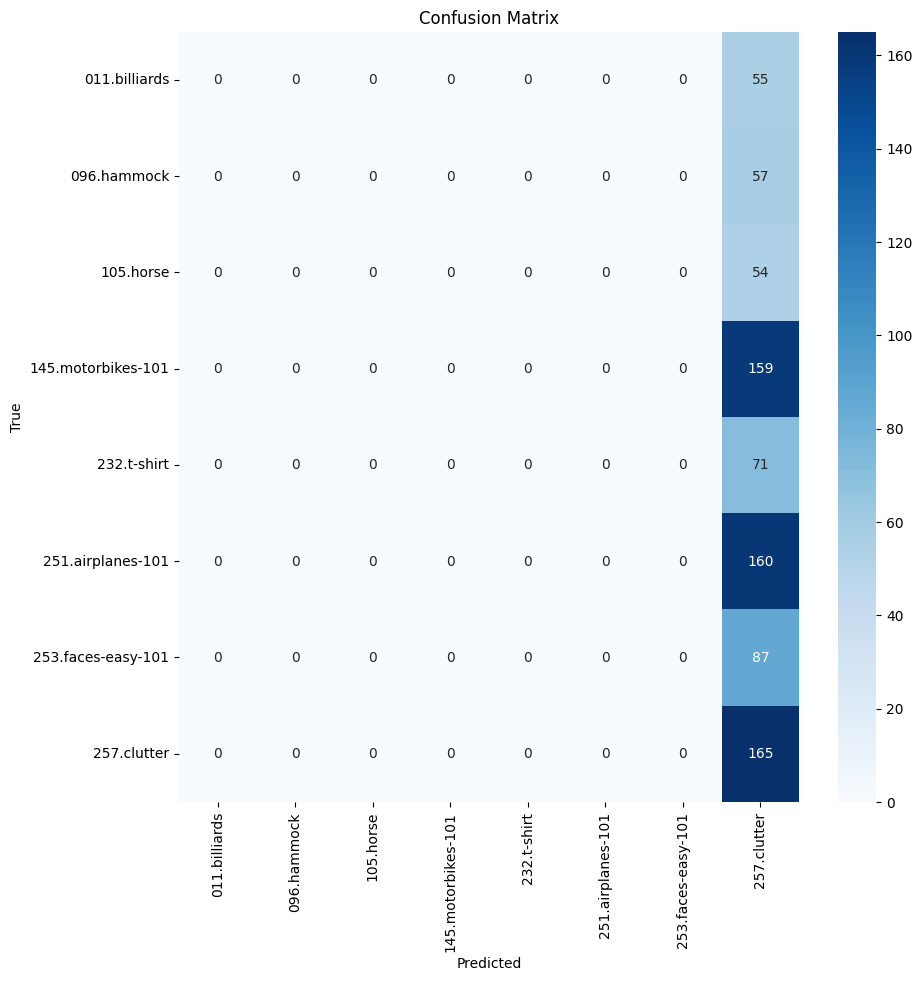

Classification Report:
                    precision    recall  f1-score   support

     011.billiards       0.00      0.00      0.00        55
       096.hammock       0.00      0.00      0.00        57
         105.horse       0.00      0.00      0.00        54
145.motorbikes-101       0.00      0.00      0.00       159
       232.t-shirt       0.00      0.00      0.00        71
 251.airplanes-101       0.00      0.00      0.00       160
253.faces-easy-101       0.00      0.00      0.00        87
       257.clutter       0.20      1.00      0.34       165

          accuracy                           0.20       808
         macro avg       0.03      0.12      0.04       808
      weighted avg       0.04      0.20      0.07       808



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
# Tahminler
y_true = val_gen.classes
y_pred = rbf_model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_gen.class_indices.keys(), yticklabels=val_gen.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
report = classification_report(y_true, y_pred_classes, target_names=val_gen.class_indices.keys())
print(report)

# **MODEL DEĞERLENDİRİLMESİ**

150-250 Adet Görüntü Verisine Sahip Olan veri setinde 16 sınıf mevcuttur.RFB modeli için sınıf sayısı fazla olması eğitim sırasında modelin sınıflar arasındaki farklılıkları öğrenmesi daha zordur, çünkü sınıf sayısı fazla ve bu durum modeli daha kompleks bir öğrenme problemine sürükler. Model, başlangıçta düşük doğrulukla başlar ve val_accuracy sadece %2' sabit kalır. Bu durum, modelin 16 sınıfı yeterince iyi genelleştiremediğini gösterir. RFB katmanları dengesiz veri ve karmaşık sınıflar nedeniyle etkili genelleme yapamaz.

---



Veri Seti İçerisindeki 250 Adet Ve Üzeri Görüntü Verisine Sahip Olan veri setinde 8 sınıf mevcuttur ve her sınıfta daha fazla veri örnek olması modelin her bir sınıfı daha iyi öğrenmesini sağlar. RFB modellerinde daha az sınıf daha az karmaşıklık demektir. Model, daha sınırlı bir problem üzerinde çalıştığı için, öğrenmesi daha kolay hale gelir. Bu veri setinde accuracy değerin, 16 sınıflı veri setinden daha iyi bir sonuç elde edilmiştir.


---


Sonuç olarak **RFB** ve **MLP** modellerinde daha az sınıf ve örnek sayısı fazla olan veri setlerinde daha başarılı olduğu ortaya çıkmıştır. Çok sınıflı ve örnek sayıları dengesiz olan veri setlerinde **CNN** tabanlı bir model veya transfer öğrenmeye yaklaşımları (örneğin, ResNet) kullanabilir. Bu tür modeller, veri miktarından bağımsız olarak daha iyi genelleme yapabilir.
